In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from functools import reduce

/Users/michael-tu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.layers import SimpleRNN, RNN, LSTM, Embedding
from keras.optimizers import Adam, SGD
import keras.utils as utils

Using TensorFlow backend.


# Utility Functions

In [3]:
def load_pkl(path):
    return pickle.load(open(path, "rb"))

In [4]:
def load_data(data):
    keys = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']
    x = data[keys[2]] # noisy sequences will be our input to our models
    y = data[keys[0]]
    y_viterbi_decoded = data[keys[3]]
    
    x = np.array(x)
    y = np.array(y)
    y_viterbi_decoded = np.array(y_viterbi_decoded)
    
    return x, y, y_viterbi_decoded

In [5]:
def load(path):
    return load_data(load_pkl(path))

In [6]:
def load_pkl_paths_from_folder(dir_path, recursive=False):
    if recursive:
        return np.sort(list(filter(lambda x: ".pkl" in x,
                            [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(dir_path)) 
                                                 for f in fn])))
    else:
        return np.sort([dir_path + "/" + x for x in os.listdir(dir_path) if ".pkl" in x ])

In [7]:
def get_param_from_filename(filename, param):
    split_token = "_"
    if param == "k":
        split_token = "_k"
    elif param == "p":
        split_token = "_p"
    elif param == "r":
        split_token = "_r"
    elif param == "l":
        split_token = "_l"
    elif param == "e":
        split_token = "_e"
    elif param == "n":
        split_token = "_n"
    else:
        raise ValueError("unrecognized parameter", param)
        
    res = filename.split("/")[-1].split(split_token)[1].split("_")[0]
    if ".pkl" in res:
        res = res.split(".pkl")[0]
    
    return float(res)

# Data Processing

In [8]:
def train_test_split(x, y, test_ratio=0.2):
    indicies = np.arange(len(x))
    np.random.shuffle(indicies)
    
    split_inx = int(len(x) * (1-test_ratio))
    X_train, X_test = x[indicies[:split_inx]], x[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    
    return X_train, X_test, y_train, y_test

In [9]:
def group_sort(benchmark, *args):
    sorted_indicies = np.argsort(benchmark) 
    
    benchmark = np.array(benchmark)
    args = list(map(lambda x: np.array(x), args))
    
    benchmark_sorted = benchmark[sorted_indicies]
    args_sorted = list(map(lambda x: x[sorted_indicies], args))
    
    return benchmark_sorted, args_sorted

In [10]:
def one_hot(data):
    res = []
    for d in data:
        res.append([0,0])
        res[-1][int(d)] = 1
    return np.array(res)

def one_hot_datasets(y):
    return np.array(list(map(lambda x: one_hot(x), y)))

def onehot_to_normal(dataset):
    return np.argmax(dataset, axis=2)

In [11]:
variable_desc = {
    "k": "message length (K-bit)",
    "p": "prob P of Bernoulli distribution",
    "e": "corruption probability E",
    "l": "constraint length L"
}

In [13]:
def build_data_from_path(path, test_ratio=0.2, X_reshape=None):
    X, y, y_viterbi_decoded = load(path)
    y_oh = one_hot_datasets(y)
    
    if X_reshape:
        total_shape = np.product(X_reshape[1:])
        if total_shape != X.shape[1]:
            X = X[:,:total_shape]
        X = X.reshape(X_reshape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_ratio=test_ratio)
    
    return (X_train, y_train), (X_test, y_test), (X, y, y_oh, y_viterbi_decoded)

# Model Definitions

Optimizers

In [14]:
optimizers = {
    "adam": Adam, 
    "sgd":  SGD
}

Fully Connected Neural Net

In [15]:
default_fnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.01,
    "learing_rate": 0.015,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [16]:
default_fnn_architecture = [32,64,100]

Convolution 1D Nerual Net

In [17]:
default_cnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

Avaliable Layers:

Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D

In [18]:
default_cnn_architecture = [
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("flatten"),
    ("dense", 200),
    ("dropout")
]

# Model Construction

In [19]:
def build_fnn(input_shape, 
              output_shape, 
              architecture=default_fnn_architecture, 
              param=default_fnn_param):
    """
    Train a FNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, output_units in enumerate(architecture):
        if i == 0:
            model.add(Dense(output_units, activation=param["activation"],
                        input_shape=input_shape,
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
        else:
            model.add(Dense(output_units, activation=param["activation"],
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [20]:
def train_fnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

In [21]:
def build_cnn(input_shape, 
              output_shape, 
              architecture=default_cnn_architecture, 
              param=default_cnn_param):
    """
    Train a CNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, layer in enumerate(architecture):
        if layer[0] == "conv1d":
            model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
        elif layer[0] == "flatten":
            model.add(Flatten())
        elif layer[0] == "dense":
            model.add(Dense(layer[1], activation=param["activation"]))
        elif layer[0] == "dropout":
            model.add(Dropout(param["dropout_keep_prob"]))
        else:
            raise ValueError("do not recognize layer", layer[0])
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [22]:
def train_cnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

# Evaluation Metrics

In [23]:
def accuracy(y, y_pred, argmax=False, viterbi=False):
    y_pred_binary = y_pred
    
    if viterbi:
        y_pred_binary = [p[:y.shape[1]] for p in y_pred]
    elif argmax:
        y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
        assert y.shape == y_pred_binary.shape, "prediction and ground truth must \
        have same shape\nExpected:{0} Actual:{1}".format(y.shape, y_pred_binary.shape)
    
    return np.sum(y == y_pred_binary) / np.product(y.shape)

In [24]:
def model_accuracy(model, x, y, argmax=False):
    if argmax:
        y_pred = model.predict(x)
        return accuracy(y, y_pred, argmax)
    else:
        return model.evaluate(x, y, verbose=0)[1]

In [25]:
def pred_vs_truth(model, x, y, n_show=2, y_truth_is_onehot=False):
    indicies = np.random.randint(low=0, high=x.shape[0], size=n_show)
    y_pred = model.predict(x[indicies])
    y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
    
    truth = y[indicies].astype(y_pred_binary.dtype)
    
    if y_truth_is_onehot:
        truth = onehot_to_normal(truth)
    
    for i in range(len(truth)):
        print("\n############## Example {0} ##############".format(i))
        print("Expected:\n", truth[i])
        print("Actual:\n", y_pred_binary[i])

# Graph

In [26]:
def plot_acc(title, acc):
    epoch = np.arange(1,len(acc)+1,1)
    
    plt.figure(figsize=(20,6))

    plt.subplot(121)
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, acc, "green")

    plt.subplot(122)
    plt.title("Log Log {0}".format(title))
    plt.xlabel('epoch')
    plt.ylabel("accuracy")
    plt.plot(epoch, np.log(-np.log(acc)), "red")

# Experiments

In [58]:
data_path = "../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl"

In [59]:
experiment_results = dict()

### k: 10, e: 0.05

model 1

In [60]:
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

In [62]:
lr = 0.005
model = Sequential()

model.add(Embedding(2, 10))
model.add(Dropout(0.5))

model.add(LSTM(200, activation="tanh", input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=25, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/25
 - 10s - loss: 0.6591 - acc: 0.5603 - val_loss: 0.5936 - val_acc: 0.6036
Epoch 2/25
 - 9s - loss: 0.5919 - acc: 0.6200 - val_loss: 0.5557 - val_acc: 0.6433
Epoch 3/25
 - 9s - loss: 0.5477 - acc: 0.6614 - val_loss: 0.4922 - val_acc: 0.7047
Epoch 4/25
 - 7s - loss: 0.4960 - acc: 0.7112 - val_loss: 0.4378 - val_acc: 0.7599
Epoch 5/25
 - 8s - loss: 0.4596 - acc: 0.7497 - val_loss: 0.3944 - val_acc: 0.7995
Epoch 6/25
 - 10s - loss: 0.4113 - acc: 0.7908 - val_loss: 0.3342 - val_acc: 0.8405
Epoch 7/25
 - 9s - loss: 0.3636 - acc: 0.8222 - val_loss: 0.2808 - val_acc: 0.8750
Epoch 8/25
 - 8s - loss: 0.3164 - acc: 0.8513 - val_loss: 0.2336 - val_acc: 0.8979
Epoch 9/25
 - 8s - loss: 0.2737 - acc: 0.8760 - val_loss: 0.1909 - val_acc: 0.9159
Epoch 10/25
 - 7s - loss: 0.2398 - acc: 0.8964 - val_loss: 0.1566 - val_acc: 0.9370
Epoch 11/25
 - 7s - loss: 0.2057 - acc: 0.9139 - val_loss: 0.1327 - val_acc: 0.9528
Epoch 12/25
 - 7s - loss: 0.1819 -

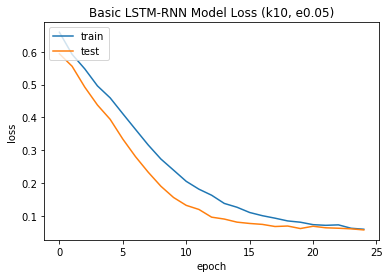

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))
pred_vs_truth(model, X_test, y_test, n_show=3, y_truth_is_onehot=True)

Test Accuracy is 0.9817099990844727

############## Example 0 ##############
Expected:
 [0 0 1 1 0 0 0 0 0 1]
Actual:
 [0 0 1 1 0 0 0 0 0 1]

############## Example 1 ##############
Expected:
 [0 1 1 0 1 1 1 1 1 1]
Actual:
 [0 1 1 0 1 1 1 1 1 1]

############## Example 2 ##############
Expected:
 [1 1 0 1 1 1 0 1 0 0]
Actual:
 [1 1 0 1 1 1 0 1 0 0]


In [44]:
# model.save("../models/v6/rnn_k10_e0.05.h5")
# experiment_results["k10_e0.05"] = {
#     "model": model,
#     "history": history
# }

model 2

In [66]:
print(X_train.shape)
print(y_train.shape)

(20000, 24)
(20000, 10, 2)


In [70]:
seq_length = 3

In [105]:
def prepare_data_for_lstm(X_train):
    X_train2 = list()
    for x in X_train:
        x2 = list()
        for i in range(0, len(x) - seq_length, 1):
            x2.append(x[i:i+seq_length])
        X_train2.append(np.array(x2))
    X_train2 = np.array(X_train2)
    return X_train2

In [107]:
X_train2 = prepare_data_for_lstm(X_train)
X_test2 = prepare_data_for_lstm(X_test)

In [108]:
print(X_train2.shape)
print(X_test2.shape)

(20000, 21, 3)
(5000, 21, 3)


In [103]:
lr = 0.01
model = Sequential()

model.add(LSTM(200, activation="tanh", input_shape=(21, 3), return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train2, y_train, epochs=25, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/25
 - 8s - loss: 0.6202 - acc: 0.5872 - val_loss: 0.5408 - val_acc: 0.6515
Epoch 2/25
 - 7s - loss: 0.5131 - acc: 0.6717 - val_loss: 0.4509 - val_acc: 0.7236
Epoch 3/25
 - 7s - loss: 0.4466 - acc: 0.7413 - val_loss: 0.4034 - val_acc: 0.7599
Epoch 4/25
 - 6s - loss: 0.3753 - acc: 0.7985 - val_loss: 0.2939 - val_acc: 0.8443
Epoch 5/25
 - 7s - loss: 0.2966 - acc: 0.8561 - val_loss: 0.2070 - val_acc: 0.9038
Epoch 6/25
 - 6s - loss: 0.2252 - acc: 0.9020 - val_loss: 0.1222 - val_acc: 0.9552
Epoch 7/25
 - 6s - loss: 0.1664 - acc: 0.9337 - val_loss: 0.0946 - val_acc: 0.9672
Epoch 8/25
 - 7s - loss: 0.1318 - acc: 0.9503 - val_loss: 0.0709 - val_acc: 0.9755
Epoch 9/25
 - 6s - loss: 0.1047 - acc: 0.9632 - val_loss: 0.0592 - val_acc: 0.9796
Epoch 10/25
 - 6s - loss: 0.0914 - acc: 0.9681 - val_loss: 0.0583 - val_acc: 0.9802
Epoch 11/25
 - 7s - loss: 0.0803 - acc: 0.9723 - val_loss: 0.0494 - val_acc: 0.9824
Epoch 12/25
 - 6s - loss: 0.0761 - a

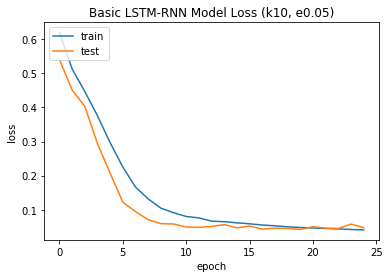

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [110]:
print("Test Accuracy is", model_accuracy(model, X_test2, y_test, argmax=False))
pred_vs_truth(model, X_test2, y_test, n_show=3, y_truth_is_onehot=True)

Test Accuracy is 0.9839000007629395

############## Example 0 ##############
Expected:
 [1 0 0 1 0 0 1 0 0 0]
Actual:
 [1 0 0 1 0 0 1 0 0 0]

############## Example 1 ##############
Expected:
 [1 1 1 0 0 0 0 0 1 1]
Actual:
 [1 1 1 0 0 0 0 0 1 1]

############## Example 2 ##############
Expected:
 [1 0 1 0 0 0 1 0 1 0]
Actual:
 [1 0 1 0 0 0 1 0 1 0]


In [117]:
lr = 0.005
model = Sequential()

model.add(LSTM(100, activation="tanh", input_shape=(21, 3), return_sequences=False))
model.add(Dropout(0.5))

# model.add(Dense(200, activation="relu"))
# model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train2, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 4s - loss: 0.6777 - acc: 0.5515 - val_loss: 0.6408 - val_acc: 0.6174
Epoch 2/20
 - 3s - loss: 0.5792 - acc: 0.6391 - val_loss: 0.5132 - val_acc: 0.7084
Epoch 3/20
 - 2s - loss: 0.4862 - acc: 0.7315 - val_loss: 0.4225 - val_acc: 0.7917
Epoch 4/20
 - 3s - loss: 0.4115 - acc: 0.7988 - val_loss: 0.3682 - val_acc: 0.8296
Epoch 5/20
 - 4s - loss: 0.3483 - acc: 0.8394 - val_loss: 0.3013 - val_acc: 0.8667
Epoch 6/20
 - 3s - loss: 0.3062 - acc: 0.8638 - val_loss: 0.2566 - val_acc: 0.8939
Epoch 7/20
 - 3s - loss: 0.2671 - acc: 0.8876 - val_loss: 0.2127 - val_acc: 0.9164
Epoch 8/20
 - 3s - loss: 0.2336 - acc: 0.9047 - val_loss: 0.1862 - val_acc: 0.9306
Epoch 9/20
 - 3s - loss: 0.2030 - acc: 0.9208 - val_loss: 0.1536 - val_acc: 0.9449
Epoch 10/20
 - 3s - loss: 0.1782 - acc: 0.9334 - val_loss: 0.1344 - val_acc: 0.9530
Epoch 11/20
 - 3s - loss: 0.1614 - acc: 0.9409 - val_loss: 0.1334 - val_acc: 0.9526
Epoch 12/20
 - 3s - loss: 0.1476 - a

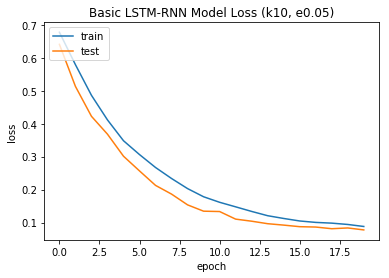

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
print("Test Accuracy is", model_accuracy(model, X_test2, y_test, argmax=False))

Test Accuracy is 0.9742400020599365


In [125]:
lr = 0.01
model = Sequential()

model.add(LSTM(20, activation="tanh", input_shape=(21, 3), return_sequences=False))
model.add(Dropout(0.5))

# model.add(Dense(200, activation="relu"))
# model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train2, y_train, epochs=50, batch_size=512, verbose=1,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 3s 174us/step - loss: 0.6796 - acc: 0.5536 - val_loss: 0.6383 - val_acc: 0.5802
Epoch 2/50
16000/16000 [==============================] - 1s 45us/step - loss: 0.6090 - acc: 0.6002 - val_loss: 0.5653 - val_acc: 0.6421
Epoch 3/50
16000/16000 [==============================] - 1s 48us/step - loss: 0.5616 - acc: 0.6439 - val_loss: 0.5236 - val_acc: 0.6874
Epoch 4/50
16000/16000 [==============================] - 1s 51us/step - loss: 0.5364 - acc: 0.6773 - val_loss: 0.4973 - val_acc: 0.7159
Epoch 5/50
16000/16000 [==============================] - 1s 47us/step - loss: 0.5170 - acc: 0.7021 - val_loss: 0.4727 - val_acc: 0.7559
Epoch 6/50
16000/16000 [==============================] - 1s 68us/step - loss: 0.5015 - acc: 0.7227 - val_loss: 0.4534 - val_acc: 0.7651
Epoch 7/50
16000/16000 [==============================] - 1s 57us/step - loss: 0.4901 - acc: 0.7341 - val_loss: 0.4387 - val_acc

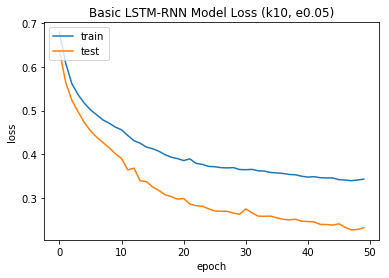

In [126]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [127]:
print("Test Accuracy is", model_accuracy(model, X_test2, y_test, argmax=False))

Test Accuracy is 0.913969997882843


In [139]:
lr = 0.01
model = Sequential()

model.add(LSTM(60, activation="tanh", input_shape=(21, 3), return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train2, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 5s - loss: 0.6703 - acc: 0.5603 - val_loss: 0.6340 - val_acc: 0.6033
Epoch 2/20
 - 1s - loss: 0.6020 - acc: 0.6168 - val_loss: 0.5594 - val_acc: 0.6605
Epoch 3/20
 - 1s - loss: 0.5345 - acc: 0.6904 - val_loss: 0.4723 - val_acc: 0.7586
Epoch 4/20
 - 1s - loss: 0.4599 - acc: 0.7642 - val_loss: 0.3976 - val_acc: 0.8032
Epoch 5/20
 - 1s - loss: 0.4012 - acc: 0.8008 - val_loss: 0.3471 - val_acc: 0.8347
Epoch 6/20
 - 1s - loss: 0.3614 - acc: 0.8260 - val_loss: 0.3068 - val_acc: 0.8522
Epoch 7/20
 - 1s - loss: 0.3260 - acc: 0.8475 - val_loss: 0.2677 - val_acc: 0.8826
Epoch 8/20
 - 1s - loss: 0.2981 - acc: 0.8647 - val_loss: 0.2317 - val_acc: 0.9032
Epoch 9/20
 - 1s - loss: 0.2669 - acc: 0.8832 - val_loss: 0.2005 - val_acc: 0.9197
Epoch 10/20
 - 1s - loss: 0.2403 - acc: 0.8991 - val_loss: 0.1706 - val_acc: 0.9369
Epoch 11/20
 - 1s - loss: 0.2153 - acc: 0.9122 - val_loss: 0.1459 - val_acc: 0.9485
Epoch 12/20
 - 1s - loss: 0.1939 - a

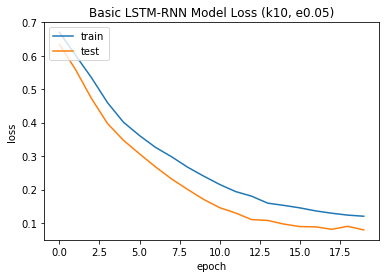

In [140]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [141]:
print("Test Accuracy is", model_accuracy(model, X_test2, y_test, argmax=False))

Test Accuracy is 0.9724800010681153


In [143]:
data_path = "../data/dataset_04/data/dataset_n25000_k20_e0.05.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)
print(X_train.shape)
print(X_test.shape)

(20000, 41, 3)
(5000, 41, 3)


Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 13s - loss: 0.6774 - acc: 0.5343 - val_loss: 0.6418 - val_acc: 0.5648
Epoch 2/20
 - 6s - loss: 0.6190 - acc: 0.5928 - val_loss: 0.5804 - val_acc: 0.6400
Epoch 3/20
 - 6s - loss: 0.5624 - acc: 0.6639 - val_loss: 0.5251 - val_acc: 0.6993
Epoch 4/20
 - 6s - loss: 0.5216 - acc: 0.7044 - val_loss: 0.4875 - val_acc: 0.7317
Epoch 5/20
 - 5s - loss: 0.4869 - acc: 0.7341 - val_loss: 0.4454 - val_acc: 0.7667
Epoch 6/20
 - 5s - loss: 0.4558 - acc: 0.7584 - val_loss: 0.4186 - val_acc: 0.7819
Epoch 7/20
 - 6s - loss: 0.4333 - acc: 0.7754 - val_loss: 0.3897 - val_acc: 0.8060
Epoch 8/20
 - 6s - loss: 0.4089 - acc: 0.7932 - val_loss: 0.3795 - val_acc: 0.8150
Epoch 9/20
 - 6s - loss: 0.3946 - acc: 0.8033 - val_loss: 0.3472 - val_acc: 0.8282
Epoch 10/20
 - 5s - loss: 0.3723 - acc: 0.8176 - val_loss: 0.3300 - val_acc: 0.8416
Epoch 11/20
 - 7s - loss: 0.3564 - acc: 0.8272 - val_loss: 0.3089 - val_acc: 0.8610
Epoch 12/20
 - 5s - loss: 0.3368 - 

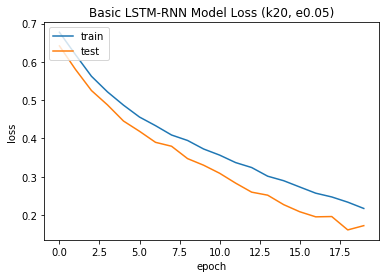

In [149]:
lr = 0.01
model = Sequential()

model.add(LSTM(100, activation="tanh", input_shape=X_train.shape[1:], return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k20, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [150]:
data_path = "../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)
print(X_train.shape)
print(X_test.shape)

(20000, 21, 3)
(5000, 21, 3)


In [151]:
X_train = utils.np_utils.normalize(X_train)

In [156]:
lr = 0.01
model = Sequential()

model.add(LSTM(100, activation="tanh", input_shape=X_train.shape[1:], return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 6s - loss: 0.6557 - acc: 0.5806 - val_loss: 0.5986 - val_acc: 0.6359
Epoch 2/20
 - 3s - loss: 0.5449 - acc: 0.6901 - val_loss: 0.4647 - val_acc: 0.7495
Epoch 3/20
 - 3s - loss: 0.4413 - acc: 0.7681 - val_loss: 0.3696 - val_acc: 0.8274
Epoch 4/20
 - 3s - loss: 0.3599 - acc: 0.8291 - val_loss: 0.3000 - val_acc: 0.8627
Epoch 5/20
 - 3s - loss: 0.3000 - acc: 0.8670 - val_loss: 0.2249 - val_acc: 0.9097
Epoch 6/20
 - 3s - loss: 0.2448 - acc: 0.8983 - val_loss: 0.1762 - val_acc: 0.9333
Epoch 7/20
 - 3s - loss: 0.1964 - acc: 0.9247 - val_loss: 0.1445 - val_acc: 0.9471
Epoch 8/20
 - 3s - loss: 0.1604 - acc: 0.9407 - val_loss: 0.1060 - val_acc: 0.9615
Epoch 9/20
 - 3s - loss: 0.1352 - acc: 0.9517 - val_loss: 0.0989 - val_acc: 0.9637
Epoch 10/20
 - 2s - loss: 0.1195 - acc: 0.9577 - val_loss: 0.0911 - val_acc: 0.9683
Epoch 11/20
 - 2s - loss: 0.1067 - acc: 0.9628 - val_loss: 0.0808 - val_acc: 0.9707
Epoch 12/20
 - 2s - loss: 0.0953 - a

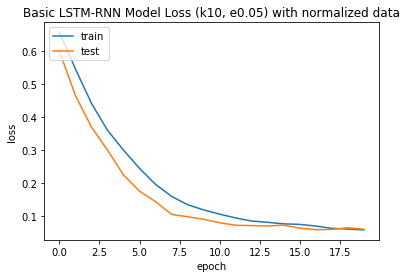

In [161]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Basic LSTM-RNN Model Loss (k10, e0.05) with normalized data')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [162]:
data_path = "../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)

lr = 0.01
model = Sequential()

model.add(LSTM(100, activation="tanh", input_shape=X_train.shape[1:], return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history2 = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 7s - loss: 0.6617 - acc: 0.5681 - val_loss: 0.5877 - val_acc: 0.6385
Epoch 2/20
 - 3s - loss: 0.5290 - acc: 0.6786 - val_loss: 0.4691 - val_acc: 0.7312
Epoch 3/20
 - 3s - loss: 0.4513 - acc: 0.7644 - val_loss: 0.3738 - val_acc: 0.8220
Epoch 4/20
 - 3s - loss: 0.3536 - acc: 0.8330 - val_loss: 0.2719 - val_acc: 0.8754
Epoch 5/20
 - 2s - loss: 0.2736 - acc: 0.8804 - val_loss: 0.1955 - val_acc: 0.9236
Epoch 6/20
 - 2s - loss: 0.2129 - acc: 0.9135 - val_loss: 0.1413 - val_acc: 0.9494
Epoch 7/20
 - 3s - loss: 0.1648 - acc: 0.9385 - val_loss: 0.1062 - val_acc: 0.9641
Epoch 8/20
 - 3s - loss: 0.1365 - acc: 0.9516 - val_loss: 0.0949 - val_acc: 0.9686
Epoch 9/20
 - 3s - loss: 0.1232 - acc: 0.9576 - val_loss: 0.0812 - val_acc: 0.9711
Epoch 10/20
 - 3s - loss: 0.1054 - acc: 0.9634 - val_loss: 0.0739 - val_acc: 0.9745
Epoch 11/20
 - 3s - loss: 0.0955 - acc: 0.9667 - val_loss: 0.0741 - val_acc: 0.9744
Epoch 12/20
 - 3s - loss: 0.0895 - a

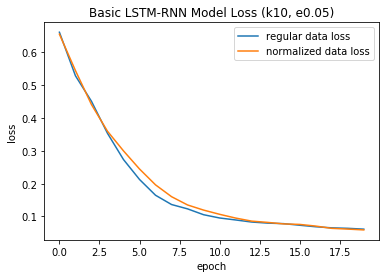

In [166]:
plt.plot(history2.history['loss'], label="regular data loss")
plt.plot(history.history['loss'], label="normalized data loss")

plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

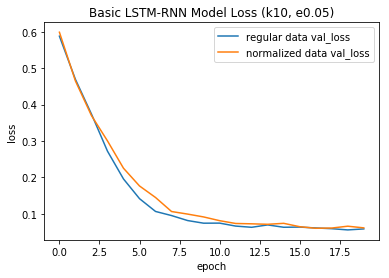

In [167]:
plt.plot(history2.history['val_loss'], label="regular data val_loss")
plt.plot(history.history['val_loss'], label="normalized data val_loss")

plt.title('Basic LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [170]:
from keras.layers import Bidirectional

In [172]:
data_path = "../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)

lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(100, activation="tanh", return_sequences=False), input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 11s - loss: 0.5988 - acc: 0.6383 - val_loss: 0.4522 - val_acc: 0.7557
Epoch 2/20
 - 5s - loss: 0.3800 - acc: 0.8056 - val_loss: 0.2690 - val_acc: 0.8829
Epoch 3/20
 - 5s - loss: 0.2354 - acc: 0.9008 - val_loss: 0.1605 - val_acc: 0.9391
Epoch 4/20
 - 5s - loss: 0.1497 - acc: 0.9452 - val_loss: 0.1006 - val_acc: 0.9641
Epoch 5/20
 - 4s - loss: 0.1103 - acc: 0.9612 - val_loss: 0.0773 - val_acc: 0.9723
Epoch 6/20
 - 5s - loss: 0.0847 - acc: 0.9705 - val_loss: 0.0634 - val_acc: 0.9774
Epoch 7/20
 - 5s - loss: 0.0723 - acc: 0.9751 - val_loss: 0.0521 - val_acc: 0.9814
Epoch 8/20
 - 5s - loss: 0.0612 - acc: 0.9789 - val_loss: 0.0535 - val_acc: 0.9802
Epoch 9/20
 - 5s - loss: 0.0569 - acc: 0.9803 - val_loss: 0.0508 - val_acc: 0.9817
Epoch 10/20
 - 5s - loss: 0.0510 - acc: 0.9824 - val_loss: 0.0450 - val_acc: 0.9836
Epoch 11/20
 - 5s - loss: 0.0461 - acc: 0.9842 - val_loss: 0.0459 - val_acc: 0.9840
Epoch 12/20
 - 5s - loss: 0.0420 - 

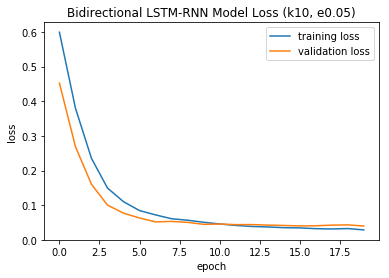

In [173]:
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title('Bidirectional LSTM-RNN Model Loss (k10, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [174]:
data_path = "../data/dataset_04/data/dataset_n25000_k20_e0.05.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)

lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(100, activation="tanh", return_sequences=False), input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 20s - loss: 0.6529 - acc: 0.5686 - val_loss: 0.5753 - val_acc: 0.6350
Epoch 2/20
 - 13s - loss: 0.5288 - acc: 0.6903 - val_loss: 0.4550 - val_acc: 0.7534
Epoch 3/20
 - 10s - loss: 0.4353 - acc: 0.7733 - val_loss: 0.3755 - val_acc: 0.8125
Epoch 4/20
 - 11s - loss: 0.3713 - acc: 0.8153 - val_loss: 0.3178 - val_acc: 0.8513
Epoch 5/20
 - 12s - loss: 0.3206 - acc: 0.8478 - val_loss: 0.2712 - val_acc: 0.8813
Epoch 6/20
 - 10s - loss: 0.2739 - acc: 0.8760 - val_loss: 0.2311 - val_acc: 0.9033
Epoch 7/20
 - 9s - loss: 0.2404 - acc: 0.8956 - val_loss: 0.1922 - val_acc: 0.9237
Epoch 8/20
 - 12s - loss: 0.2088 - acc: 0.9123 - val_loss: 0.1668 - val_acc: 0.9356
Epoch 9/20
 - 11s - loss: 0.1849 - acc: 0.9255 - val_loss: 0.1442 - val_acc: 0.9471
Epoch 10/20
 - 8s - loss: 0.1614 - acc: 0.9369 - val_loss: 0.1251 - val_acc: 0.9531
Epoch 11/20
 - 8s - loss: 0.1422 - acc: 0.9459 - val_loss: 0.1097 - val_acc: 0.9609
Epoch 12/20
 - 8s - loss: 0.

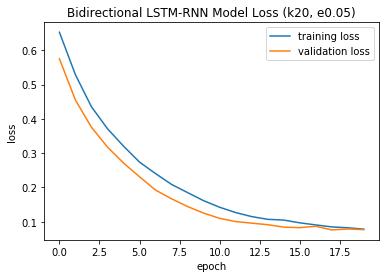

In [175]:
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title('Bidirectional LSTM-RNN Model Loss (k20, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [177]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))

Test Accuracy is 0.9698800017356872


In [178]:
data_path = "../data/dataset_04/data/dataset_n25000_k10_e0.15.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)

lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(100, activation="tanh", return_sequences=False), input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(20, activation="sigmoid"))
model.add(Reshape((10,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 15s - loss: 0.6376 - acc: 0.5948 - val_loss: 0.5614 - val_acc: 0.6549
Epoch 2/20
 - 9s - loss: 0.5202 - acc: 0.6922 - val_loss: 0.4757 - val_acc: 0.7354
Epoch 3/20
 - 9s - loss: 0.4635 - acc: 0.7431 - val_loss: 0.4244 - val_acc: 0.7784
Epoch 4/20
 - 8s - loss: 0.4251 - acc: 0.7789 - val_loss: 0.3948 - val_acc: 0.8023
Epoch 5/20
 - 8s - loss: 0.3926 - acc: 0.8065 - val_loss: 0.3540 - val_acc: 0.8335
Epoch 6/20
 - 9s - loss: 0.3648 - acc: 0.8263 - val_loss: 0.3356 - val_acc: 0.8454
Epoch 7/20
 - 7s - loss: 0.3417 - acc: 0.8422 - val_loss: 0.3046 - val_acc: 0.8637
Epoch 8/20
 - 9s - loss: 0.3220 - acc: 0.8544 - val_loss: 0.2913 - val_acc: 0.8724
Epoch 9/20
 - 16s - loss: 0.3027 - acc: 0.8665 - val_loss: 0.2710 - val_acc: 0.8841
Epoch 10/20
 - 10s - loss: 0.2868 - acc: 0.8749 - val_loss: 0.2691 - val_acc: 0.8856
Epoch 11/20
 - 10s - loss: 0.2754 - acc: 0.8804 - val_loss: 0.2570 - val_acc: 0.8898
Epoch 12/20
 - 8s - loss: 0.2648

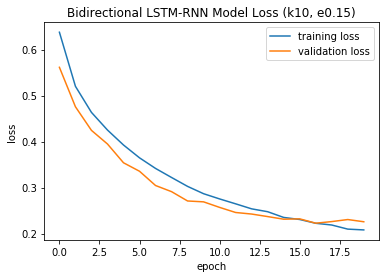

In [179]:
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title('Bidirectional LSTM-RNN Model Loss (k10, e0.15)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [180]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))

Test Accuracy is 0.9039299993515014


In [181]:
data_path = "../data/dataset_04/data/dataset_n25000_k20_e0.15.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)

lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(100, activation="tanh", return_sequences=False), input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(40, activation="sigmoid"))
model.add(Reshape((20,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 21s - loss: 0.6662 - acc: 0.5481 - val_loss: 0.6282 - val_acc: 0.5759
Epoch 2/20
 - 13s - loss: 0.6063 - acc: 0.5989 - val_loss: 0.5821 - val_acc: 0.6210
Epoch 3/20
 - 13s - loss: 0.5741 - acc: 0.6365 - val_loss: 0.5564 - val_acc: 0.6596
Epoch 4/20
 - 13s - loss: 0.5545 - acc: 0.6637 - val_loss: 0.5364 - val_acc: 0.6869
Epoch 5/20
 - 13s - loss: 0.5333 - acc: 0.6904 - val_loss: 0.5156 - val_acc: 0.7096
Epoch 6/20
 - 13s - loss: 0.5154 - acc: 0.7109 - val_loss: 0.4950 - val_acc: 0.7296
Epoch 7/20
 - 13s - loss: 0.4999 - acc: 0.7264 - val_loss: 0.4795 - val_acc: 0.7437
Epoch 8/20
 - 13s - loss: 0.4853 - acc: 0.7387 - val_loss: 0.4695 - val_acc: 0.7537
Epoch 9/20
 - 15s - loss: 0.4737 - acc: 0.7478 - val_loss: 0.4553 - val_acc: 0.7632
Epoch 10/20
 - 15s - loss: 0.4602 - acc: 0.7589 - val_loss: 0.4427 - val_acc: 0.7750
Epoch 11/20
 - 14s - loss: 0.4471 - acc: 0.7691 - val_loss: 0.4299 - val_acc: 0.7838
Epoch 12/20
 - 15s - loss

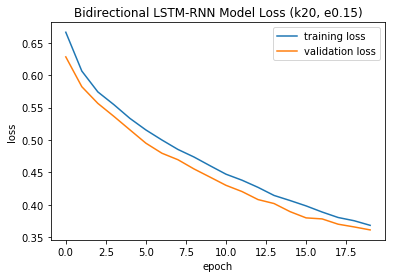

In [182]:
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title('Bidirectional LSTM-RNN Model Loss (k20, e0.15)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [183]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))

Test Accuracy is 0.8338400002479553


In [184]:
data_path = "../data/dataset_04/data/dataset_n25000_k40_e0.05.pkl"
train, test, original = build_data_from_path(data_path)
X_train, y_train = train
X_test, y_test = test
X, y, y_oh, y_viterbi_decoded = original

X_train = prepare_data_for_lstm(X_train)
X_test = prepare_data_for_lstm(X_test)

lr = 0.01
model = Sequential()

model.add(Bidirectional(LSTM(200, activation="tanh", return_sequences=False), input_shape=X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(80, activation="sigmoid"))
model.add(Reshape((40,2)))

opt = optimizers["adam"](lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, verbose=2,
          shuffle=True, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
 - 50s - loss: 0.6741 - acc: 0.5341 - val_loss: 0.6436 - val_acc: 0.5548
Epoch 2/20
 - 41s - loss: 0.6255 - acc: 0.5792 - val_loss: 0.5894 - val_acc: 0.6209
Epoch 3/20
 - 52s - loss: 0.5628 - acc: 0.6525 - val_loss: 0.5168 - val_acc: 0.6978
Epoch 4/20
 - 46s - loss: 0.5006 - acc: 0.7146 - val_loss: 0.4584 - val_acc: 0.7526
Epoch 5/20
 - 43s - loss: 0.4482 - acc: 0.7589 - val_loss: 0.4037 - val_acc: 0.7922
Epoch 6/20
 - 44s - loss: 0.4001 - acc: 0.7954 - val_loss: 0.3609 - val_acc: 0.8213
Epoch 7/20
 - 40s - loss: 0.3653 - acc: 0.8183 - val_loss: 0.3330 - val_acc: 0.8390
Epoch 8/20
 - 41s - loss: 0.3363 - acc: 0.8363 - val_loss: 0.3035 - val_acc: 0.8567
Epoch 9/20
 - 39s - loss: 0.3145 - acc: 0.8502 - val_loss: 0.2772 - val_acc: 0.8734
Epoch 10/20
 - 48s - loss: 0.2883 - acc: 0.8657 - val_loss: 0.2569 - val_acc: 0.8843
Epoch 11/20
 - 43s - loss: 0.2664 - acc: 0.8778 - val_loss: 0.2322 - val_acc: 0.9009
Epoch 12/20
 - 41s - loss

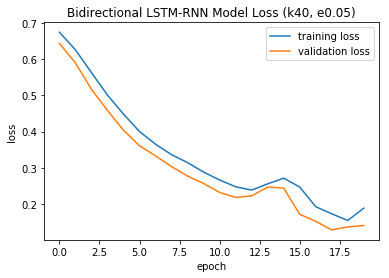

In [185]:
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title('Bidirectional LSTM-RNN Model Loss (k40, e0.05)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [186]:
print("Test Accuracy is", model_accuracy(model, X_test, y_test, argmax=False))

Test Accuracy is 0.9512725004196168
